# Classifier for Credit Default Prediction

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
!pip install lightgbm --install-option=--gpu
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import dill as pickle
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
import shap


In [2]:
data = pd.read_excel("../data/raw/default of credit card clients.xls", sheet_name="Data")
data.shape

(30001, 25)

In [3]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [4]:
pd.get_dummies(data.iloc[1:,1:], columns=['X2','X3','X4'], drop_first=False).astype(float).head(6)

,X1,X5,X6,X7,X8,X9,X10,X11,X12,X13,...,X3_1,X3_2,X3_3,X3_4,X3_5,X3_6,X4_0,X4_1,X4_2,X4_3
1,20000.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,120000.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,90000.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,50000.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,48233.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,50000.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,5670.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,50000.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,57069.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
def data_prep(df):
    # remove unnecessary 1st column and columne names in 1st row
    data = df.iloc[1:, 1:].copy()
    # one-hot encoding
    categorical_cols = ['X2','X3','X4']
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    ohe_array = ohe.fit_transform(data[categorical_cols])
    ohe_array = ohe_array.astype(int) # converting booleans to 0/1
    ohe_cols = ohe.get_feature_names_out(categorical_cols)
    # merge ohe with original data
    data_ohe = pd.DataFrame(ohe_array, columns=ohe_cols, index=data.index)
    # remove original categorical cols
    data_final = pd.concat([data.drop(columns=categorical_cols), data_ohe], axis=1)
    # convert target col to 0/1
    data_final['Y'] = data_final['Y'].astype(int)

    return data_final

In [6]:
# prepare data
prep_data = data_prep(data)
prep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 1 to 30000
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X1      30000 non-null  object
 1   X5      30000 non-null  object
 2   X6      30000 non-null  object
 3   X7      30000 non-null  object
 4   X8      30000 non-null  object
 5   X9      30000 non-null  object
 6   X10     30000 non-null  object
 7   X11     30000 non-null  object
 8   X12     30000 non-null  object
 9   X13     30000 non-null  object
 10  X14     30000 non-null  object
 11  X15     30000 non-null  object
 12  X16     30000 non-null  object
 13  X17     30000 non-null  object
 14  X18     30000 non-null  object
 15  X19     30000 non-null  object
 16  X20     30000 non-null  object
 17  X21     30000 non-null  object
 18  X22     30000 non-null  object
 19  X23     30000 non-null  object
 20  Y       30000 non-null  int64 
 21  X2_1    30000 non-null  int64 
 22  X2_2    30000 non-null

#### for handling imbalanced class

In [7]:
# pre-computing sample weights once and for all
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=prep_data['Y'])
X = prep_data.drop('Y', axis=1)
y = prep_data['Y'].astype(int)

#### Feature Selections

In [8]:
# -----------------------------------------------------------
# 1. Pearson (Correlation-based selection)
# -----------------------------------------------------------
corr_df = pd.DataFrame(X.join(y).corr()['Y'].sort_values())
corr_df['abs'] = corr_df['Y'].abs()

corr_features = list(
    corr_df.loc[(corr_df['abs'] >= 0.08) & (corr_df.index != 'Y')].index
)

print("-----------------------------------")
print("Correlation-based Important Features")
print("-----------------------------------")
print(corr_features)

# -----------------------------------------------------------
# 2. LASSO (L1 Regularization)
# -----------------------------------------------------------
lr_l1 = LogisticRegression(
    penalty='l1',
    C=1,
    solver='liblinear',
    max_iter=500
)

lr_l1.fit(X, y, sample_weight=sample_weights)

sfm_l1 = SelectFromModel(lr_l1, prefit=True)
lasso_features = list(X.columns[sfm_l1.get_support()])

print("\n-----------------------------------")
print("LASSO-based Important Features")
print("-----------------------------------")
print(lasso_features)

# -----------------------------------------------------------
# 3. Tree-Based (ExtraTrees)
# -----------------------------------------------------------
tree_model = ExtraTreesClassifier(
    n_estimators=200,
    random_state=42
)

tree_model.fit(X, y, sample_weight=sample_weights)

sfm_tree = SelectFromModel(tree_model, prefit=True)
tree_features = list(X.columns[sfm_tree.get_support()])

print("\n-----------------------------------")
print("Tree-based Important Features")
print("-----------------------------------")
print(tree_features)

# -----------------------------------------------------------
# 4. PCA → RFE
# -----------------------------------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.99)
X_reduced = pca.fit_transform(X_scaled)

N = pca.n_components_
print("\nNumber of PCA components for 99% variance:", N)

rfe = RFE(
    estimator=DecisionTreeClassifier(),
    n_features_to_select=N
)

rfe.fit(X, y, sample_weight=sample_weights)

rfe_features = list(X.columns[rfe.support_])

print("\n-----------------------------------")
print("RFE-based Important Features")
print("-----------------------------------")
print(rfe_features)


-----------------------------------
Correlation-based Important Features
-----------------------------------
['X1', 'X11', 'X10', 'X9', 'X8', 'X7', 'X6']

-----------------------------------
LASSO-based Important Features
-----------------------------------
['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X18', 'X2_2', 'X3_0', 'X3_1', 'X3_2', 'X3_3', 'X3_4', 'X3_5', 'X4_0', 'X4_1', 'X4_2']

-----------------------------------
Tree-based Important Features
-----------------------------------
['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']

Number of PCA components for 99% variance: 14

-----------------------------------
RFE-based Important Features
-----------------------------------
['X1', 'X5', 'X6', 'X12', 'X13', 'X14', 'X15', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


#### Creting subsets from original dataset basis each feature set

In [9]:
# append target variable to form complete set cols to 
# for creating multiple datasets for training & benchmarking
corr_features.append('Y')
lasso_features.append('Y')
tree_features.append('Y')
rfe_features.append('Y')
all_features = X.columns.tolist()
all_features.append('Y')

In [10]:
print(corr_features)
print(lasso_features)
print(tree_features)
print(rfe_features)
print(all_features)

['X1', 'X11', 'X10', 'X9', 'X8', 'X7', 'X6', 'Y']
['X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X18', 'X2_2', 'X3_0', 'X3_1', 'X3_2', 'X3_3', 'X3_4', 'X3_5', 'X4_0', 'X4_1', 'X4_2', 'Y']
['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'Y']
['X1', 'X5', 'X6', 'X12', 'X13', 'X14', 'X15', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'Y']
['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X2_1', 'X2_2', 'X3_0', 'X3_1', 'X3_2', 'X3_3', 'X3_4', 'X3_5', 'X3_6', 'X4_0', 'X4_1', 'X4_2', 'X4_3', 'Y']


#### Benchmarking multiple classifiers (algos) across multiple feature sets

In [ ]:
# ============================================================
# Feature subsets 
# ============================================================

feature_sets = [
    corr_features,
    lasso_features,
    tree_features,
    rfe_features,
    all_features      
]

dataset_names = [
    'corr_feat_dataset',
    'lasso_feat_dataset',
    'tree_feat_dataset',
    'rfe_feat_dataset',
    'all_feat_dataset'
]

# ============================================================
# Creating datasets for each feature set
# ============================================================

datasets = []
for fs in feature_sets:
    ds = prep_data.loc[:, fs].reset_index(drop=True)
    datasets.append(ds)

# ============================================================
# Queueing multiple Classifiers for running against mutiple FS
# ============================================================

names = [
    "Nearest Neighbors",
    "Logistic Regression",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "MLP Neural Net",
    "AdaBoost",
    "Gaussian NB",
    "Quadratic DA",
    "XGBoost",
    "LightGBM"
]

classifiers = [
    KNeighborsClassifier(
        n_neighbors=10, p=1, 
        weights='distance'
        ),
    LogisticRegression(
        max_iter=1000, 
        class_weight='balanced'   # class balancing
        ),
    SVC(
      kernel="rbf", 
      gamma=2, 
      C=1, 
      probability=True, 
      class_weight='balanced'
    ),       # <--- takes lot of time; uncomment only if you've patience
    DecisionTreeClassifier(
        max_depth=5, 
        class_weight='balanced'   # class balancing
        ),
    RandomForestClassifier(
        max_depth=10, 
        n_estimators=400, 
        max_features='sqrt', 
        min_samples_leaf=2, 
        min_samples_split=5
        ),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(reg_param=0.1),
    XGBClassifier(
        tree_method="auto",
        predictor="gpu_predictor",
        device="gpu",
        eval_metric="logloss",
        learning_rate=0.01,
        max_depth=7,
        n_esstimators=400,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])  # class balancing
    ),
    LGBMClassifier(
        device="gpu",
        boosting_type="gbdt",
        gpu_platform_id=1,
        gpu_device_id=1,
        random_state=29,
        n_jobs=-1,
        verbose=-1,         # muting c++ logs
        verbosity=-1,       # muting GPU backend logs too
    )
]

In [27]:
# ================================================================
# Full Benchmarking across Feature Sets and various Classifiers
# ================================================================

modelling_df = pd.DataFrame(
    columns=[
        'feats_subset', 'algo',
        'train-precision', 'train-recall', 'train-f1', 'train-acc',
        'val-precision', 'val-recall', 'val-f1', 'val-acc'
    ]
)

i = 0

for ds_cnt in range(len(datasets)):
    print(f"\n Dataset: {dataset_names[ds_cnt]}")
    ds = datasets[ds_cnt]

    X_sub = ds.drop(columns=['Y'])
    y_sub = ds['Y']

    # Standardize numeric features only
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)

    # Stratified train - test dataset split
    sss = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=29)
    for train_idx, val_idx in sss.split(X_scaled, y_sub):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_sub.iloc[train_idx], y_sub.iloc[val_idx]
        
        y_train = y_train.squeeze().astype(int)
        y_val = y_val.squeeze().astype(int)

    # Benchmark models
    for clf_cnt in tqdm(range(len(classifiers)), desc="Algorithms", position=0):
        
        clf = classifiers[clf_cnt]
        name = names[clf_cnt]

        modelling_df.at[i, 'feats_subset'] = dataset_names[ds_cnt]
        modelling_df.at[i, 'algo'] = name

        clf.fit(X_train, y_train)

        # Train CV
        y_pred_train = cross_val_predict(clf, X_train, y_train, cv=5, method="predict")

        modelling_df.at[i, 'train-precision'] = precision_score(y_train, y_pred_train)
        modelling_df.at[i, 'train-recall'] = recall_score(y_train, y_pred_train)
        modelling_df.at[i, 'train-f1'] = f1_score(y_train, y_pred_train)
        modelling_df.at[i, 'train-acc'] = accuracy_score(y_train, y_pred_train)

        # Validation CV
        y_pred_val = cross_val_predict(clf, X_val, y_val, cv=5, method="predict")

        modelling_df.at[i, 'val-precision'] = precision_score(y_val, y_pred_val)
        modelling_df.at[i, 'val-recall'] = recall_score(y_val, y_pred_val)
        modelling_df.at[i, 'val-f1'] = f1_score(y_val, y_pred_val)
        modelling_df.at[i, 'val-acc'] = accuracy_score(y_val, y_pred_val)

        i += 1

print("\n Benchmarking complete!")



 Dataset: corr_feat_dataset


Algorithms: 100%|██████████| 11/11 [04:03<00:00, 22.16s/it]



 Dataset: lasso_feat_dataset


Algorithms: 100%|██████████| 11/11 [06:22<00:00, 34.75s/it]



 Dataset: tree_feat_dataset


Algorithms: 100%|██████████| 11/11 [08:34<00:00, 46.76s/it]



 Dataset: rfe_feat_dataset


Algorithms: 100%|██████████| 11/11 [06:58<00:00, 38.00s/it]



 Dataset: all_feat_dataset


Algorithms: 100%|██████████| 11/11 [11:06<00:00, 60.57s/it]


 Benchmarking complete!


In [28]:
modelling_df.sort_values(['val-acc'], ascending=False).head()

,feats_subset,algo,train-precision,train-recall,train-f1,train-acc,val-precision,val-recall,val-f1,val-acc
16,lasso_feat_dataset,MLP Neural Net,0.683472,0.33563,0.450188,0.818667,0.690114,0.364641,0.477161,0.823222
39,rfe_feat_dataset,AdaBoost,0.691095,0.320775,0.438171,0.818048,0.698075,0.346057,0.462727,0.822222
50,all_feat_dataset,AdaBoost,0.68678,0.32099,0.4375,0.817429,0.698869,0.341537,0.458839,0.821778
38,rfe_feat_dataset,MLP Neural Net,0.693917,0.306997,0.425672,0.816762,0.704762,0.334505,0.453678,0.821778
37,rfe_feat_dataset,Random Forest,0.69241,0.335845,0.452305,0.820095,0.697651,0.343044,0.459933,0.821778


In [29]:
modelling_df.sort_values(['val-f1','val-acc'], ascending=False)

,feats_subset,algo,train-precision,train-recall,train-f1,train-acc,val-precision,val-recall,val-f1,val-acc
31,tree_feat_dataset,XGBoost,0.486854,0.593972,0.535105,0.771714,0.507347,0.589653,0.545412,0.782556
53,all_feat_dataset,XGBoost,0.487555,0.594618,0.53579,0.772095,0.50341,0.593169,0.544616,0.780556
3,corr_feat_dataset,Decision Tree,0.500469,0.573735,0.534604,0.779048,0.501486,0.593169,0.543488,0.779556
9,corr_feat_dataset,XGBoost,0.5016,0.573735,0.535248,0.779619,0.511062,0.58011,0.543402,0.784333
20,lasso_feat_dataset,XGBoost,0.502992,0.561033,0.530429,0.780286,0.517399,0.567554,0.541317,0.787222
42,rfe_feat_dataset,XGBoost,0.468348,0.60366,0.527464,0.760762,0.497867,0.586138,0.538408,0.777667
14,lasso_feat_dataset,Decision Tree,0.498018,0.567922,0.530678,0.77781,0.492575,0.583124,0.534039,0.774889
25,tree_feat_dataset,Decision Tree,0.458095,0.586006,0.514216,0.755095,0.459584,0.599699,0.520375,0.755444
47,all_feat_dataset,Decision Tree,0.457835,0.585576,0.513886,0.754952,0.459168,0.598694,0.51973,0.755222
36,rfe_feat_dataset,Decision Tree,0.411739,0.601076,0.48871,0.72181,0.458462,0.598694,0.519277,0.754778


In [31]:
modelling_df.sort_values(['val-f1','val-acc'], ascending=False).to_csv("../outputs/model_benchmarks.csv", index=False)

### Fine-tuning best performers

In [55]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import ParameterSampler

# ------------------------------
# Prepare Data
# ------------------------------
ds = prep_data.loc[:, tree_features].reset_index(drop=True)
X = ds.drop(columns=['Y'])
y = ds['Y']

X_tuned = StandardScaler().fit_transform(X)
y_tuned = y

# 5-fold CV repeated 3 times
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=29)

# ==========================================================
# XGBOOST FINE-TUNING
# ==========================================================

xgb_param_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.001, 0.01, 0.05, 0.1],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "gamma": [0, 1, 5, 10],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [0.5, 1, 2],
}

param_list = list(ParameterSampler(xgb_param_grid, n_iter=50, random_state=29))

results = []
for params in tqdm(param_list, desc="XGBoost Fine-tune", unit="combination"):
    xgb = XGBClassifier(
        tree_method='auto',
        predictor='gpu_predictor',
        device="gpu",
        random_state=29,
        **params
    )
    xgb.fit(X_train, y_train)
    preds = xgb.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, preds)
    results.append((params, score))

print("Benchmarking best hyperparameters for Fine-tuning:")
fine_tune_params_df = pd.DataFrame(results, columns=["Params", "ROC AUC Score"]).sort_values(by="ROC AUC Score", ascending=False).reset_index(drop=True)

fine_tune_params_df.head(20)

XGBoost Fine-tune: 100%|██████████| 50/50 [00:32<00:00,  1.55combination/s]

Benchmarking best hyperparameters for Fine-tuning:


,Params,ROC AUC Score
0,"{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alp...",0.788666
1,"{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...",0.788474
2,"{'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alp...",0.788151
3,"{'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha...",0.788084
4,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",0.788072
5,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",0.787663
6,"{'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha...",0.786995
7,"{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha...",0.786977
8,"{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...",0.786906
9,"{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha...",0.786731


In [56]:
# best hyper-parameters
best_params = fine_tune_params_df.iloc[0,0]
best_params

{'subsample': 0.8,
 'reg_lambda': 0.5,
 'reg_alpha': 0,
 'n_estimators': 800,
 'min_child_weight': 7,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 5,
 'colsample_bytree': 0.7}

#### Model Pipeline

In [62]:
# rem target label from best feature set
tree_features = [f for f in tree_features if f != 'Y']
print(tree_features)

['X1', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']


In [ ]:
# filter for best feature set
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.loc[:, self.attribute_names].copy()

# if categorical cols (X2, X3, X4) present in selected featureset, perform OHE
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols
        self.ohe = OneHotEncoder(sparse_output=False, drop=None)
        self.ohe_cols = None

    def fit(self, X, y=None):
        if any(col in X.columns for col in self.categorical_cols):
            self.ohe.fit(X[self.categorical_cols])
            self.ohe_cols = self.ohe.get_feature_names_out(self.categorical_cols)
        return self
    
    def transform(self, X):
        X = X.copy()
        if any(col in X.columns for col in self.categorical_cols):
            ohe_array = self.ohe.transform(X[self.categorical_cols]).astype(int)
            ohe_df = pd.DataFrame(ohe_array, columns=self.ohe_cols, index=X.index)
            X = pd.concat([X.drop(columns=self.categorical_cols), ohe_df], axis=1)
        return X

# hyper-params fine-tuned classifier
xgb = XGBClassifier(
        tree_method='auto',
        predictor='gpu_predictor',
        device="gpu",
        **best_params
    )

# everything into a pipeline
pipeline = Pipeline([
    ('feat_selector', FeatureSelector(tree_features)),
    ('ohe', CatEncoder(['X2','X3','X4'])),
    ('scaler', StandardScaler()),
    ('clf', xgb)
])

# dataset
ds = data.iloc[1:, 1:].copy()
X = ds.drop('Y', axis=1)
y = ds['Y'].astype(int)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=29)

for train_idx, val_idx in sss.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

# fit pipeline on training split
pipeline.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feat_selector', ...), ('ohe', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,attribute_names,"['X1', 'X5', ...]"
,categorical_cols,"['X2', 'X3', ...]"
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None


In [88]:
# predict on validation set
val_pred = pipeline.predict(X_val)

# classification report
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7009
           1       0.70      0.37      0.49      1991

    accuracy                           0.83      9000
   macro avg       0.77      0.66      0.69      9000
weighted avg       0.81      0.83      0.80      9000



In [89]:
val_probs = pipeline.predict_proba(X_val)[:, 1]
threshold = 0.5
val_pred_thresh = (val_probs >= threshold).astype(int)
print(classification_report(y_val, val_pred_thresh))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90      7009
           1       0.70      0.37      0.49      1991

    accuracy                           0.83      9000
   macro avg       0.77      0.66      0.69      9000
weighted avg       0.81      0.83      0.80      9000



#### Optimizing Prediction Threshold

In [79]:
# assessing the best threshold for maximum F1 value (best of precision at best recall)
def compute_threshold_metrics(pipeline, X_val, y_val, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 200)

    proba = pipeline.predict_proba(X_val)[:, 1]

    precision_list = []
    recall_list = []
    f1_list = []

    for t in thresholds:
        pred = (proba >= t).astype(int)
        precision_list.append(precision_score(y_val, pred))
        recall_list.append(recall_score(y_val, pred))
        f1_list.append(f1_score(y_val, pred))

    return thresholds, precision_list, recall_list, f1_list

In [90]:
thresholds, precision_list, recall_list, f1_list = compute_threshold_metrics(pipeline, X_val, y_val)

best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
best_f1 = f1_list[best_idx]

print("Best threshold:", best_threshold)
print("Best F1:", best_f1)
print("Precision:", precision_list[best_idx])
print("Recall:", recall_list[best_idx])

Best threshold: 0.23653266331658293
Best F1: 0.5741648106904231
Precision: 0.5158063225290116
Recall: 0.6474133601205424


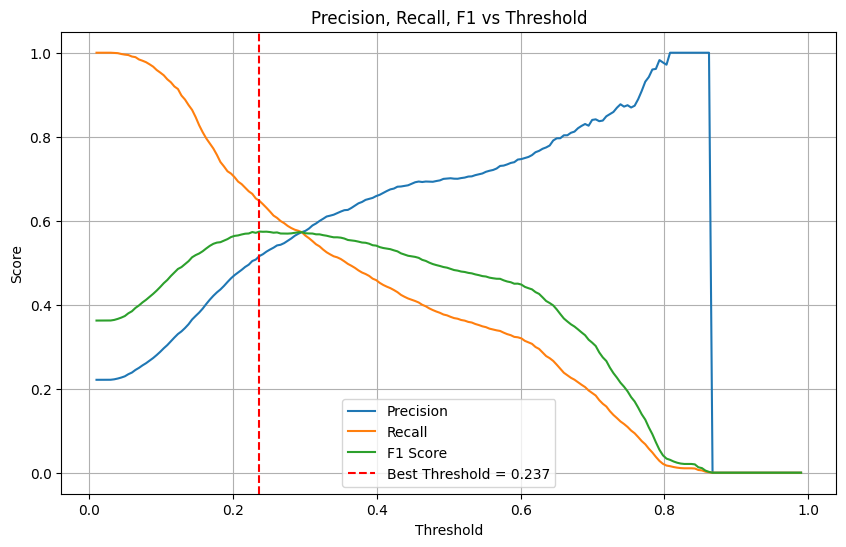

In [91]:
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.3f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
val_probs = pipeline.predict_proba(X_val)[:, 1]
threshold = 0.237
val_pred_thresh = (val_probs >= threshold).astype(int)
print(classification_report(y_val, val_pred_thresh))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      7009
           1       0.52      0.65      0.57      1991

    accuracy                           0.79      9000
   macro avg       0.70      0.74      0.72      9000
weighted avg       0.81      0.79      0.80      9000



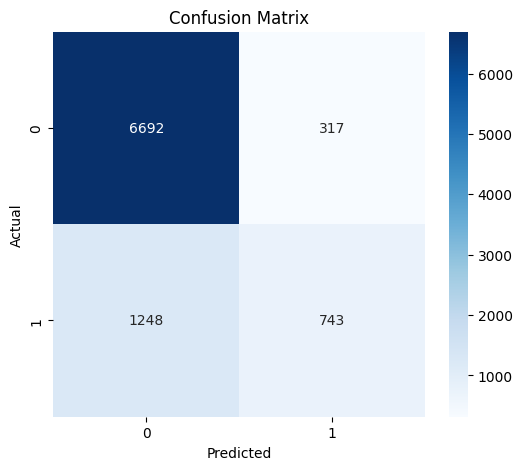

In [94]:
cm = confusion_matrix(y_val, val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [95]:
# saving the ML Model
with open("model.pkl", "wb") as file:
    pickle.dump(pipeline, file)

#### Error Analysis + Explainability

In [97]:
# Predictions and actual labels
y_pred = pipeline.predict(X_val)
y_true = y_val

# Add to a DataFrame for easy analysis
val_df = X_val.copy()
val_df['y_true'] = y_true
val_df['y_pred'] = y_pred

# Identify TP, TN, FP, FN
val_df['error_type'] = np.where(
    (val_df['y_true'] == 1) & (val_df['y_pred'] == 1), 'TP',
    np.where((val_df['y_true'] == 0) & (val_df['y_pred'] == 0), 'TN',
             np.where((val_df['y_true'] == 0) & (val_df['y_pred'] == 1), 'FP',
                      'FN'))
)
val_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X17,X18,X19,X20,X21,X22,X23,y_true,y_pred,error_type
15263,240000,2,2,2,29,0,0,0,0,0,...,196664,9000,10500,10000,7000,7300,7439,0,0,TN
9212,400000,1,1,2,28,-2,-2,-2,-2,-2,...,12215,0,2907,13863,13869,12216,29171,0,0,TN
15947,200000,2,1,1,31,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,TN
6775,200000,1,2,1,42,-1,-1,-1,-1,-2,...,0,49007,11095,0,0,0,53025,0,0,TN
26941,280000,1,5,1,39,0,0,0,0,0,...,192115,7670,7221,7091,8013,14923,7068,0,0,TN


#### Aggregating statistics by segments

In [130]:
# Example: create age bins and income bins
val_df['age_bin'] = pd.cut(val_df['X5'], bins=[18,25,35,45,55,65,100], labels=['18-25','26-35','36-45','46-55','56-65','65+'])
val_df['income_bin'] = pd.qcut(val_df['X1'], q=5, labels=False)

# Aggregate error counts
segment_stats = val_df.groupby(['error_type','age_bin']).size().unstack(fill_value=0)
# segment_stats.to_csv('outputs/error_analysis_by_age.csv')
segment_stats


age_bin,18-25,26-35,36-45,46-55,56-65,65+
error_type,,,,,,
FN,183,492,373,174,22,4
FP,51,123,84,44,13,2
TN,821,3020,1884,815,133,19
TP,125,267,202,113,34,2


In [131]:
# List of segments/features to analyze
segment_features = ['age_bin', 'income_bin', 'X2', 'X3', 'X4']

# Aggregate error counts for each segment
error_analysis = {}
for feature in segment_features:
    if feature in val_df.columns:
        stats = val_df.groupby(['error_type', feature]).size().unstack(fill_value=0)
        error_analysis[feature] = stats

# Example: show age_bin statistics
print(error_analysis['age_bin'])


age_bin     18-25  26-35  36-45  46-55  56-65  65+
error_type                                        
FN            183    492    373    174     22    4
FP             51    123     84     44     13    2
TN            821   3020   1884    815    133   19
TP            125    267    202    113     34    2


In [133]:
for feature, stats in error_analysis.items():
    stats.to_csv(f'../outputs/error_analysis_by_{feature}.csv')

In [128]:
# Feature differences (mean difference across error types)
features = X_val.columns
grouped_means = val_df.groupby('error_type')[features].mean().T
grouped_means['max_diff'] = grouped_means.max(axis=1) - grouped_means.min(axis=1)
grouped_means.sort_values('max_diff', ascending=False, inplace=True)
grouped_means.to_csv('../outputs/error_analysis_feature_diff.csv')

In [129]:
# fairness check

protected_cols = ['X2','X3','X4']  # gender, education, marital-status
fairness_metrics = val_df.groupby(protected_cols + ['error_type']).size().unstack(fill_value=0)
fairness_metrics.to_csv('../outputs/error_analysis_fairness.csv')

# Error rates per group
group_error_rates = val_df.groupby(protected_cols).apply(lambda df: pd.Series({
    'FP_rate': np.mean((df['y_true']==0) & (df['y_pred']==1)),
    'FN_rate': np.mean((df['y_true']==1) & (df['y_pred']==0)),
}))
group_error_rates.to_csv('../outputs/error_analysis_group_error_rates.csv')

#### Explainability

##### Tree-based Feature Importance

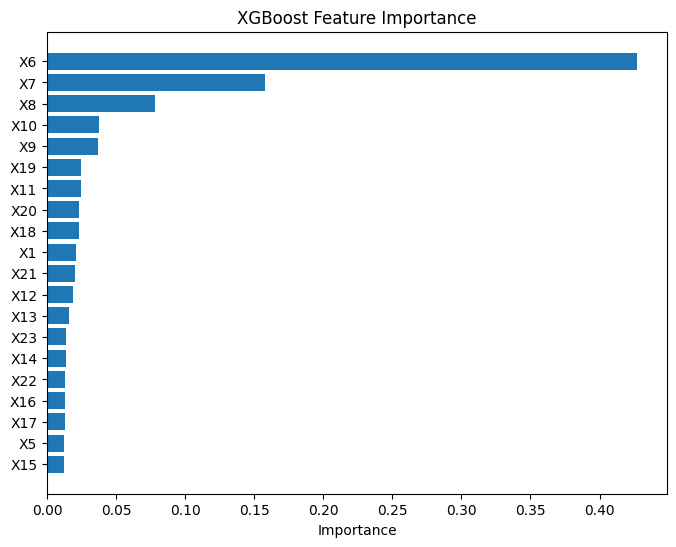

In [136]:
xgb_model = pipeline.named_steps['clf']
importance = xgb_model.feature_importances_

# Map to feature names (after selection + OHE)
feature_names = tree_features
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

# Plot top features
plt.figure(figsize=(8,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

##### Permutation Feature Importance

In [141]:
from sklearn.inspection import permutation_importance

# Use pipeline for predictions (pipeline already includes preprocessing + clf)
result = permutation_importance(
    pipeline,                # full pipeline
    X_val,                   # raw validation features
    y_val,                   # labels
    n_repeats=10,
    random_state=42,
    scoring='accuracy',
    # n_jobs=-1
)

# Feature names after preprocessing (OHE + selection)
# You can approximate by original feature names if you want
perm_imp_df = pd.DataFrame({
    'feature': X_val.columns,  
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

perm_imp_df.head(10)

,feature,importance_mean,importance_std
5,X6,0.070433,0.002002
11,X12,0.002956,0.000502
7,X8,0.002211,0.000675
0,X1,0.001489,0.000609
4,X5,0.001456,0.000513
19,X20,0.001444,0.000458
8,X9,0.001422,0.000247
9,X10,0.001367,0.000497
21,X22,0.001200,0.000486
18,X19,0.001178,0.000428


##### Partial Dependence Plots (PDP)

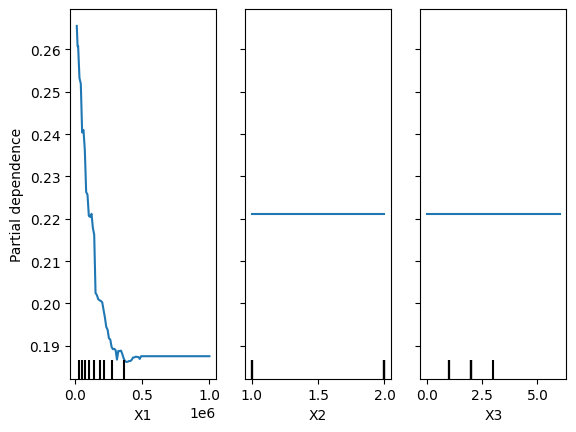

In [142]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    pipeline, 
    X_val, 
    features=[0, 1, 2],  # feature indices or names
    kind='average'
)

In [150]:
import lime
import lime.lime_tabular

# -------------------------------
# Step 1: Preprocess validation data (already in your pipeline)
# -------------------------------
X_val_transformed = pipeline.named_steps['scaler'].transform(
    pipeline.named_steps['ohe'].transform(
        pipeline.named_steps['feat_selector'].transform(X_val)
    )
).astype(np.float32)

# Get actual feature names after selection + OHE
feat_selector = pipeline.named_steps['feat_selector']
ohe = pipeline.named_steps['ohe']

selected_features = tree_features
feature_names = list(ohe.get_feature_names_out(selected_features))

# -------------------------------
# Step 2: Initialize LIME explainer
# -------------------------------
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_val_transformed,
    feature_names=feature_names,
    class_names=['0','1'],
    mode='classification'
)

# -------------------------------
# Step 3: Explain each row and store results
# -------------------------------
lime_results = []

for i in range(len(X_val_transformed)):
    exp = explainer.explain_instance(
        X_val_transformed[i],
        pipeline.predict_proba,
        num_features=10
    )
    # Convert explanation to a dict
    row_dict = {f[0]: f[1] for f in exp.as_list()}
    row_dict['row_index'] = i
    row_dict['true_label'] = y_val.iloc[i]
    lime_results.append(row_dict)

# -------------------------------
# Step 4: Convert results to DataFrame
# -------------------------------
lime_df = pd.DataFrame(lime_results).fillna(0)  # missing features get 0 contribution
lime_df.set_index('row_index', inplace=True)

# Now lime_df contains, per row, the top feature contributions for prediction
print(lime_df.head())

AttributeError: 'CatEncoder' object has no attribute 'get_feature_names_out'